In [14]:
# Importing Standard Libraries
import pandas as pd
import numpy as np
from csv import reader

# Sklearn Libraries
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import homogeneity_score, completeness_score, adjusted_mutual_info_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans, DBSCAN
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Importing mlxtend Libraries
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Graphing Libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Importing the Data Set
df =  pd.read_csv("bank.csv")
# df =  pd.read_csv("bank-full.csv")
df.head()

# Establishing copies for running through the different scrubs
df_a = df.copy()
df_b = df.copy()


# Part 2
Changing all non-numeric into category data for PCA

In [16]:
df_b['job'] = df_b['job'].astype('category')
df_b['job'] = df_b['job'].cat.codes
df_b['marital'] = df_b['marital'].astype('category')
df_b['marital'] = df_b['marital'].cat.codes
df_b['education'] = df_b['education'].astype('category')
df_b['education'] = df_b['education'].cat.codes
df_b['default'] = df_b['default'].astype('category')
df_b['default'] = df_b['default'].cat.codes
df_b['contact'] = df_b['contact'].astype('category')
df_b['contact'] = df_b['contact'].cat.codes
df_b['month'] = df_b['month'].astype('category')
df_b['month'] = df_b['month'].cat.codes
df_b['poutcome'] = df_b['poutcome'].astype('category')
df_b['poutcome'] = df_b['poutcome'].cat.codes
df_b['housing'] = df_b['housing'].astype('category')
df_b['housing'] = df_b['housing'].cat.codes
df_b['loan'] = df_b['loan'].astype('category')
df_b['loan'] = df_b['loan'].cat.codes
df_b['y'] = df_b['y'].astype('category')
df_b['y'] = df_b['y'].cat.codes
df_b = df_b.drop('pdays',axis=1)
df_b['balance'] = (df_b['balance'] - df_b['balance'].min()) / ( df_b['balance'].max() - df_b['balance'].min())
print("Post Conversion of Data into numeric, dropping pdays, and normalizing balance:")
df_b.head(10)

Post Conversion of Data into numeric, dropping pdays, and normalizing balance:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y
0,30,10,1,0,0,0.068455,0,0,0,19,10,79,1,0,3,0
1,33,7,1,1,0,0.108750,1,1,0,11,8,220,1,4,0,0
2,35,4,2,2,0,0.062590,1,0,0,16,0,185,1,1,0,0
3,30,4,1,2,0,0.064281,1,1,2,3,6,199,4,0,3,0
4,59,1,1,1,0,0.044469,1,0,2,5,8,226,1,0,3,0
5,35,4,2,2,0,0.054496,0,0,0,23,3,141,2,3,0,0
6,36,6,1,2,0,0.048590,1,0,0,14,8,341,1,2,1,0
7,39,9,1,1,0,0.046442,1,0,0,6,8,151,2,0,3,0
8,41,2,1,2,0,0.047436,1,0,2,14,8,57,2,0,3,0
9,43,7,1,0,0,0.043288,1,1,0,17,0,313,1,2,0,0


Exploratory Data Analysis

In [ ]:
df_b.info()

In [18]:
df_b.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        4521 non-null   int64  
 1   job        4521 non-null   int8   
 2   marital    4521 non-null   int8   
 3   education  4521 non-null   int8   
 4   default    4521 non-null   int8   
 5   balance    4521 non-null   float64
 6   housing    4521 non-null   int8   
 7   loan       4521 non-null   int8   
 8   contact    4521 non-null   int8   
 9   day        4521 non-null   int64  
 10  month      4521 non-null   int8   
 11  duration   4521 non-null   int64  
 12  campaign   4521 non-null   int64  
 13  previous   4521 non-null   int64  
 14  poutcome   4521 non-null   int8   
 15  y          4521 non-null   int8   
dtypes: float64(1), int64(5), int8(10)
memory usage: 256.2 KB


The Descriptions from the data right now show that the data is displaying a lot of different scales.
Namely the following
- Age
- previous
- Duration
- Month
- Day <br>

This Leads us to believe that we need to standardize the data to bring them into scale so that our
different models are not affected disproportionately

<AxesSubplot:>

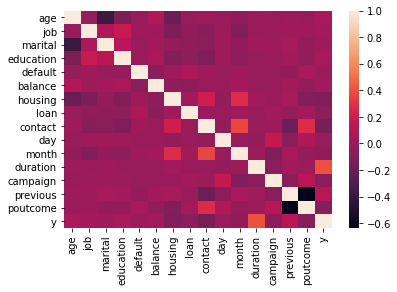

In [26]:
sns.heatmap(df_b.corr())

From the Correlation Map we can see that Y has a high correlation with marital status followed by education and housing.

Splitting the Data into X and Y

In [20]:
y = df_b["y"]
X = df_b.drop("y", axis=1)

Taking another look at the correlation of only the features

<AxesSubplot:>

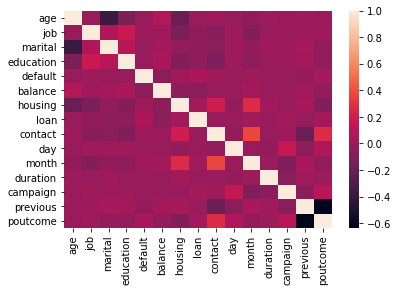

In [21]:
sns.heatmap(X.corr())

Setting the data up into training and testing splits

In [22]:
# Splitting the dataset into Train Set and Test Set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

Now I want to look at reducing the number of features and get rid of any correlation between the two

First I will want to scale the data

In [23]:
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
pca = PCA()
X_pca = pca.fit_transform(X_train_scaled)

total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = X.shape[1] - n_over_95 + 1
print("Number of Features:{}".format(n_to_reach_95))
print("Total Variance Explained:{}".format(total_explained_variance[n_to_reach_95-1]))

Number of Features:14
Total Variance Explained:0.9761810012538357


In [24]:
pipe = Pipeline([('scalar', StandardScaler()),
                 ('pca', PCA(n_components=n_to_reach_95)),
                 ('dt', tree.DecisionTreeClassifier())])
pipe.fit(X_train,y_train)

Pipeline(steps=[('scalar', StandardScaler()), ('pca', PCA(n_components=14)),
                ('dt', DecisionTreeClassifier())])

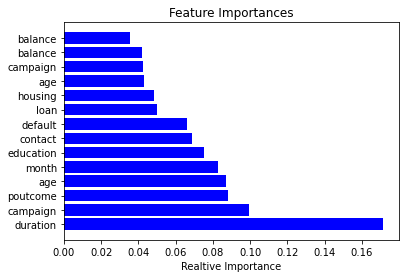

In [25]:
model = pipe.steps[1][1]
n_pcs = model.components_.shape[0]
initial_feature_names = X_train.columns
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
zipped_feats = zip(most_important_names, pipe.steps[2][1].feature_importances_)
zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)

features, importances = zip(*zipped_feats)
top_features = features[:15]
top_importances = importances[:15]

plt.title("Feature Importances")
plt.barh(range(len(top_importances)), top_importances, color='b', align='center')
plt.yticks(range(len(top_importances)), top_features)
plt.xlabel("Realtive Importance")
plt.show()

Now to Graph the decision tree to see How many features are need to get the most accurate model